In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from PIL import Image
from skimage.io import imread as imread_raw


In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.optimizers import Adam


In [ ]:
path = '/content/drive/MyDrive/researchu/segmentation/test'
os.mkdir(path)


path = '/content/drive/MyDrive/researchu/segmentation/train/augmentation'
os.mkdir(path)

FileExistsError: ignored

In [ ]:
input_dir = os.path.join('/content','drive','MyDrive','researchu')
segmentation_dir = os.path.join(input_dir,'segmentation')
segmentation_test_dir = os.path.join(segmentation_dir,'test')
segmentation_train_dir = os.path.join(segmentation_dir,'train')
segmentation_aug_dir = os.path.join(segmentation_train_dir,'augmentation')
segmentation_image_dir = os.path.join(segmentation_train_dir,'image')
segmentation_mask_dir= os.path.join(segmentation_train_dir,"mask")
segmentation_dilate_dir = os.path.join(segmentation_train_dir,"dilate")
train_dir = os.path.join(input_dir,"Thyroid_files")
image_dir = os.path.join(train_dir,"ultrasound_png")
mask_dir = os.path.join(train_dir,"mask","mask1")

DILATE_KERNEL = np.ones((15, 15), np.uint8)
BATCH_SIZE=2
EPOCHS=60

In [ ]:
def add_colored_dilate(image,mask_image,dilate_image):
     mask_image_gray = cv2.cvtColor(mask_image,cv2.COLOR_BGR2GRAY)
     dilate_image_gray = cv2.cvtColor(dilate_image,cv2.COLOR_BGR2GRAY)
     mask = cv2.bitwise_and(mask_image,mask_image,mask=mask_image_gray)
     dilate = cv2.bitwise_and(dilate_image,dilate_image,mask=dilate_image_gray)
     mask_coord = np.where(mask!=[0,0,0])
     dilate_coord = np.where(dilate!=[0,0,0])

     mask[mask_coord[0],mask_coord[1],:] = [255,0,0]
     dilate[dilate_coord[0],dilate_coord[1],:] = [0,0,255]

     ret = cv2.addWeighted(image,0.7,dilate,0.3,0)
     ret = cv2.addWeighted(ret,0.7,mask,0.3,0)

     return ret
def add_colored_mask(image,mask_image):
    mask_image_grey = cv2.cvtColor(mask_image,cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image,mask_image,mask=mask_image_grey)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:] = [255,0,0]

    ret = cv2.addWeighted(image,0.7,mask,0.3,0)

    return ret
def diff_mask(ref_image,mask_image):
    mask_image_gray = cv2.cvtColor(mask_image,cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image,mask_image,mask=mask_image_gray)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:] = [255,0,0]

    ret = cv2.addWeighted(ref_image,0.7,mask,0.3,0)
    return ret

In [ ]:
mask_dir_1 = glob(os.path.join(mask_dir,'*.png'))
test = mask_dir_1[0:62]
train = mask_dir_1[62:]
for mask_file in tqdm(mask_dir_1):
  base_file = os.path.basename(mask_file).replace("_mask","")
  image_file = os.path.join(image_dir,base_file)

  image = cv2.imread(image_file)
  mask = cv2.imread(mask_file,cv2.IMREAD_GRAYSCALE)


  mask_dilate = cv2.dilate(mask,DILATE_KERNEL,iterations=1)

  if (mask_file in strain):
        cv2.imwrite(os.path.join(segmentation_image_dir , base_file), \
                    image)
        cv2.imwrite(os.path.join(segmentation_mask_dir, base_file), \
                    mask)
        cv2.imwrite(os.path.join(segmentation_dilate_dir, base_file), \
                    mask_dilate)

  else:
    filename,fileext = os.path.splitext(base_file)
    cv2.imwrite(os.path.join(segmentation_test_dir, base_file), \
                    image)
    cv2.imwrite(os.path.join(segmentation_test_dir, \
                                 "%s_mask%s" % (filename, fileext)), mask)
    cv2.imwrite(os.path.join(segmentation_test_dir, \
                                 "%s_dilate%s" % (filename, fileext)), mask_dilate)

100%|██████████| 306/306 [02:42<00:00,  1.88it/s]


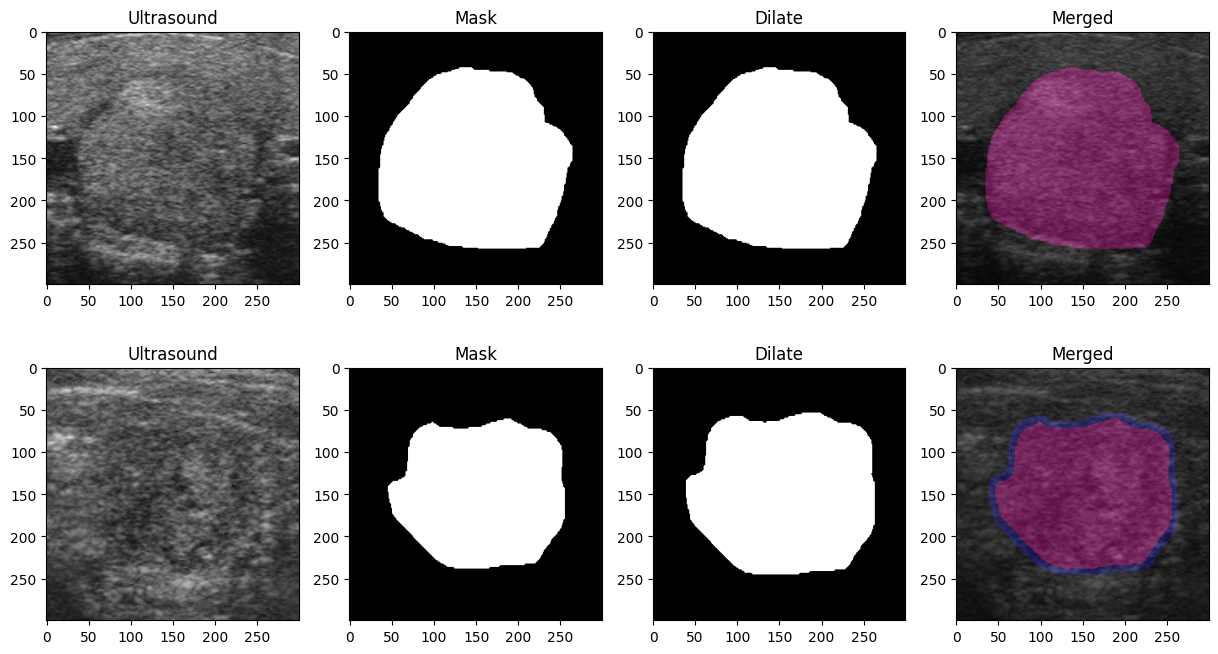

In [ ]:
base_file = os.path.basename(train[0].replace("_mask",""))
image_file = os.path.join(segmentation_image_dir,base_file)
mask_image_file = os.path.join(segmentation_dilate_dir,base_file)
dilate_image_file = os.path.join(segmentation_dilate_dir,base_file)
image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image,mask_image,dilate_image)
fig,axs = plt.subplots(2,4,figsize=(15,8))

axs[0, 0].set_title("Ultrasound")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(test[0].replace("_mask",""))
image_file = os.path.join(segmentation_test_dir,base_file)
filename,fileext = os.path.splitext(base_file)
mask_image_file = os.path.join(segmentation_test_dir, \
                               "%s_mask%s" % (filename, fileext))

filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(segmentation_test_dir, base_file)
mask_image_file = os.path.join(segmentation_test_dir, \
                               "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(segmentation_test_dir, \
                                 "%s_dilate%s" % (filename, fileext))
image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("Ultrasound")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)

In [ ]:
train_files = glob(os.path.join(segmentation_image_dir, "*.png"))
test_files = glob(os.path.join(segmentation_test_dir, "*.png"))
mask_files = glob(os.path.join(segmentation_mask_dir, "*.png"))
dilate_files = glob(os.path.join(segmentation_dilate_dir, "*.png"))

(len(train_files), \
 len(test_files), \
 len(mask_files), \
 len(dilate_files))

(244, 186, 244, 244)

In [ ]:
def train_generator(batch_size, train_path, image_folder, mask_folder, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

In [ ]:
def mean_iou(y_true, y_pred):
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    iou = (true_positives)/(possible_negatives - true_negatives + possible_positives + K.epsilon())
    return K.mean(iou)

def sensitivity(y_true,y_pred):
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives+K.epsilon())

def specificity(y_true,y_pred):
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    return true_negatives / (possible_negatives+K.epsilon())

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


In [ ]:
ACCURACY_THRESHOLD = 0.95

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('val_binary_accuracy') > ACCURACY_THRESHOLD):
			print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
			self.model.stop_training = True

# Instantiate a callback object
callbacks = myCallback()

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # contracting path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # bottom layer
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # expansive path
    up6 = UpSampling2D(size=(2, 2))(drop5)
    up6 = Conv2D(512, 2, activation='relu', padding='same')(up6)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same')(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same')(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same')(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
def test_load_image1(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        yield test_load_image(test_file, target_size)

def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))

        cv2.imwrite(result_file, img)

In [ ]:
def add_suffix(base_file, suffix):
    filename, fileext = os.path.splitext(base_file)
    return "%s_%s%s" % (filename, suffix, fileext)

test_files = [test_file for test_file in glob(os.path.join(segmentation_test_dir, "*.png")) \
              if ("_mask" not in test_file \
                  and "_dilate" not in test_file \
                  and "_predict" not in test_file)]

validation_data = (test_load_image1(test_files[0], target_size=(256, 256)),
                    test_load_image1(add_suffix(test_files[0], "dilate"), target_size=(256, 256)))

len(test_files), len(validation_data)


(62, 2)

In [ ]:
def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img=cv2.resize(img,target_size)
    img=np.reshape(img,img.shape+(1,))
    img=np.reshape(img,(1,)+img.shape)
    return img.shape

In [ ]:
r2=test_load_image(test_files[0],target_size=(256,256))
print(r2)

(1, 256, 256, 1)


In [ ]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(BATCH_SIZE,
                            segmentation_train_dir,
                            'image',
                            'dilate',
                            train_generator_args,
                            target_size=(256,256),
                            save_to_dir=os.path.abspath(segmentation_aug_dir))

model = unet(input_size=(256,256,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, \
                  metrics=[dice_coef, 'binary_accuracy',mean_iou,sensitivity,specificity,precision,recall])
model.summary()

model_checkpoint = ModelCheckpoint('unet_thyroid_seg.hdf5',
                                   monitor='loss',
                                   verbose=1,
                                   save_best_only=True)

history = model.fit(train_gen,
                              steps_per_epoch=len(train_files) / BATCH_SIZE,
                              epochs=EPOCHS,
                              callbacks=[model_checkpoint],
                              validation_data = validation_data)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

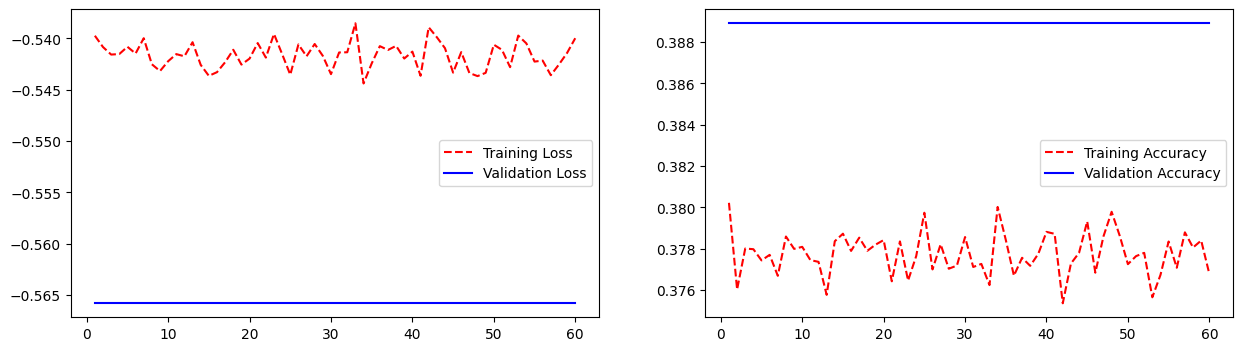

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy = history.history['binary_accuracy']
validation_accuracy = history.history['val_binary_accuracy']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

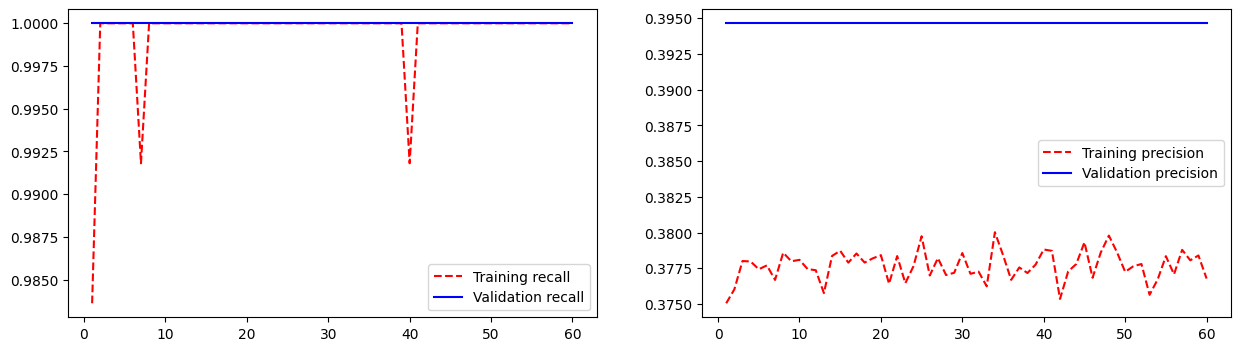

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_recall = history.history['recall']
validation_recall = history.history['val_recall']

training_precision = history.history['precision']
validation_precision = history.history['val_precision']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_recall, 'r--')
axs[0].plot(epoch_count, validation_recall, 'b-')
axs[0].legend(['Training recall', 'Validation recall'])

axs[1].plot(epoch_count, training_precision, 'r--')
axs[1].plot(epoch_count, validation_precision, 'b-')
axs[1].legend(['Training precision', 'Validation precision'])

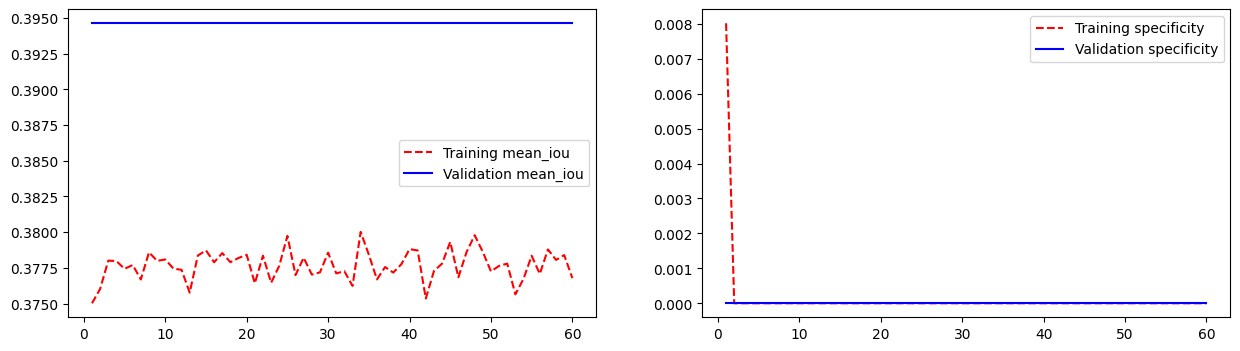

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_mean_iou = history.history['mean_iou']
validation_mean_iou = history.history['val_mean_iou']

training_specificity = history.history['specificity']
validation_specificity = history.history['val_specificity']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_mean_iou, 'r--')
axs[0].plot(epoch_count, validation_mean_iou, 'b-')
axs[0].legend(['Training mean_iou', 'Validation mean_iou'])

axs[1].plot(epoch_count, training_specificity, 'r--')
axs[1].plot(epoch_count, validation_specificity, 'b-')
axs[1].legend(['Training specificity', 'Validation specificity'])

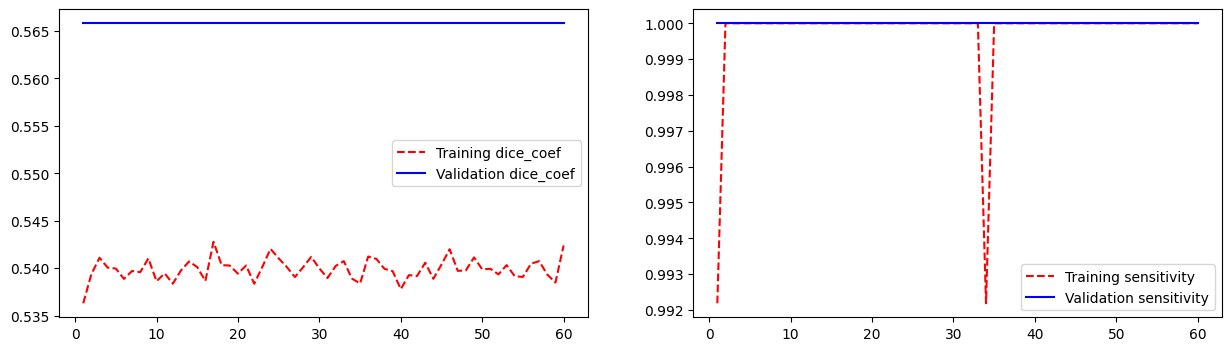

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_dice_coef = history.history['dice_coef']
validation_dice_coef = history.history['val_dice_coef']

training_sensitivity = history.history['sensitivity']
validation_sensitivity = history.history['val_sensitivity']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_dice_coef, 'r--')
axs[0].plot(epoch_count, validation_dice_coef, 'b-')
axs[0].legend(['Training dice_coef', 'Validation dice_coef'])

axs[1].plot(epoch_count, training_sensitivity, 'r--')
axs[1].plot(epoch_count, validation_sensitivity, 'b-')
axs[1].legend(['Training sensitivity', 'Validation sensitivity'])

In [ ]:
test_gen = test_generator(test_files, target_size=(256,256))
results = model.predict_generator(test_gen, len(test_files), verbose=1)
save_result(segmentation_test_dir, results, test_files)

<ipython-input-28-413e009a05ca>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  results = model.predict_generator(test_gen, len(test_files), verbose=1)


ValueError: ignored

error: ignored

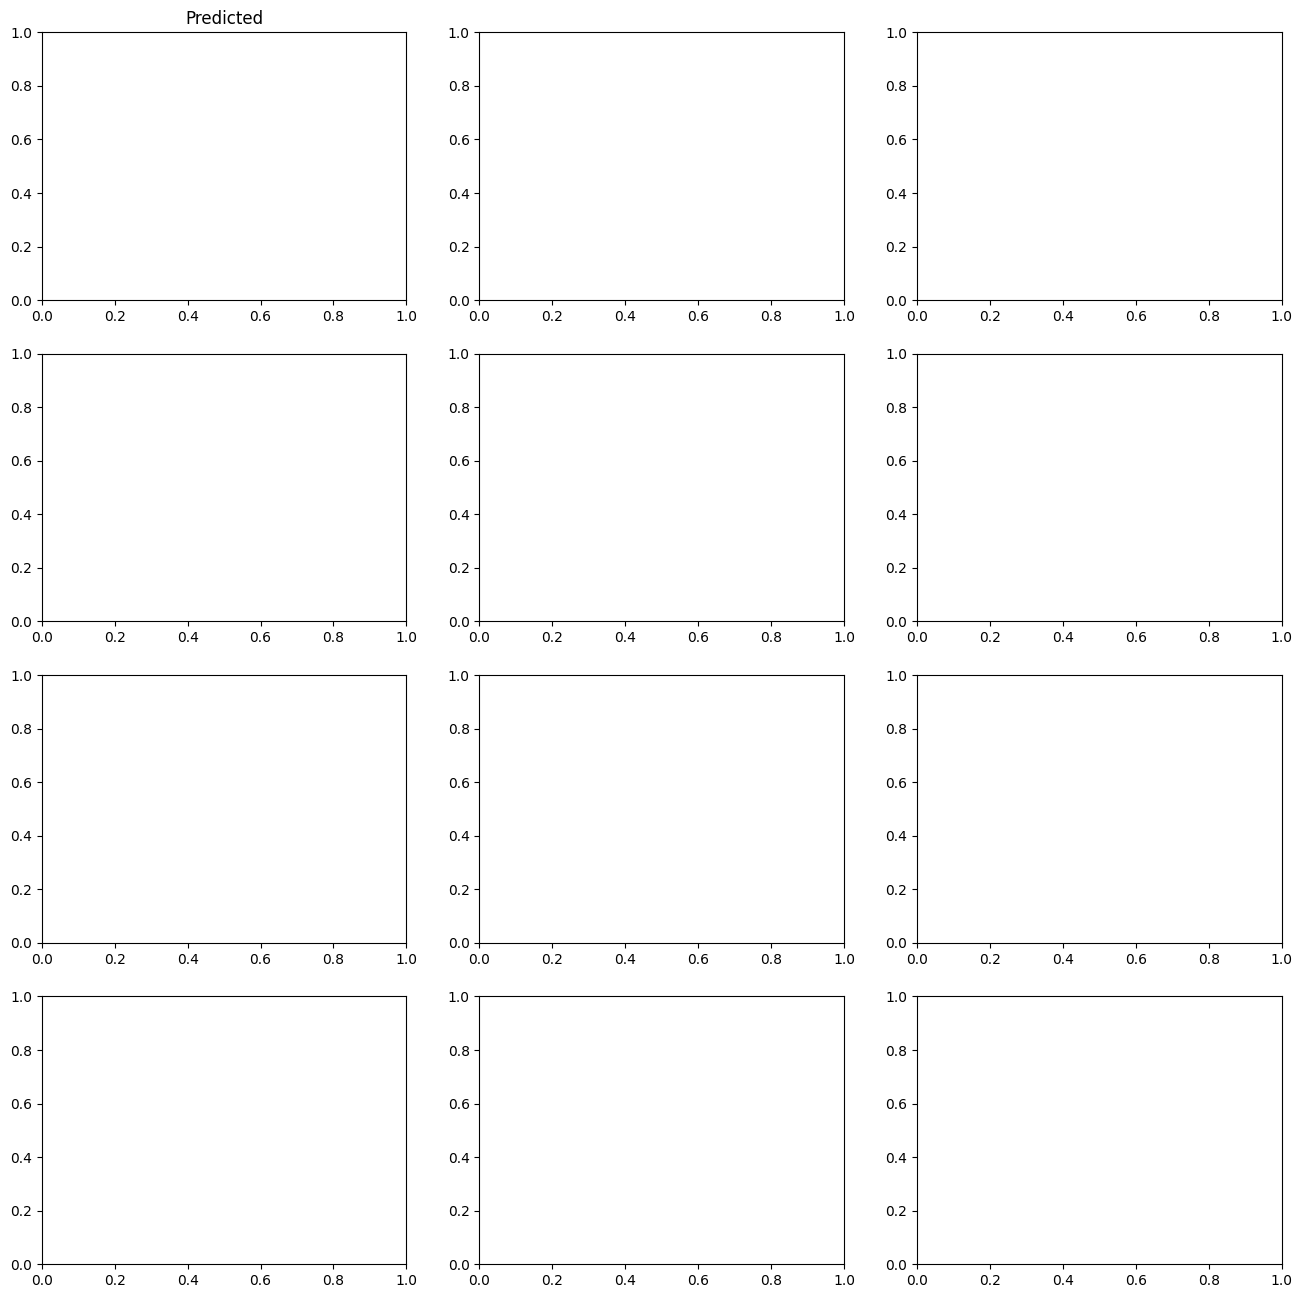

In [ ]:
image = cv2.imread("/content/drive/MyDrive/research/segmentation/test/15.png")
predict_image = cv2.imread("/content/drive/MyDrive/research/segmentation/test/15_mask.png")
mask_image = cv2.imread("/content/drive/MyDrive/research/segmentation/test/15_dilate.png")

fig, axs = plt.subplots(4, 3, figsize=(16, 16))

axs[0, 0].set_title("Predicted")
axs[0, 0].imshow(add_colored_mask(image, predict_image))
axs[0, 1].set_title("Gold Std.")
axs[0, 1].imshow(add_colored_mask(image, mask_image))
axs[0, 2].set_title("Diff.")
axs[0, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/drive/MyDrive/research/segmentation/test/16.png")
predict_image = cv2.imread("/content/drive/MyDrive/research/segmentation/test/16_mask.png")
mask_image = cv2.imread("/content/drive/MyDrive/research/segmentation/test/16_dilate.png")

axs[1, 0].set_title("Predicted")
axs[1, 0].imshow(add_colored_mask(image, predict_image))
axs[1, 1].set_title("Gold Std.")
axs[1, 1].imshow(add_colored_mask(image, mask_image))
axs[1, 2].set_title("Diff.")
axs[1, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/drive/MyDrive/research/segmentation/test/17.png")
predict_image = cv2.imread("/content/drive/MyDrive/research/segmentation/test/17_mask.png")
mask_image = cv2.imread("/content/drive/MyDrive/research/segmentation/test/17_dilate.png")

axs[2, 0].set_title("Predicted")
axs[2, 0].imshow(add_colored_mask(image, predict_image))
axs[2, 1].set_title("Gold Std.")
axs[2, 1].imshow(add_colored_mask(image, mask_image))
axs[2, 2].set_title("Diff.")
axs[2, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/drive/MyDrive/research/segmentation/test/131.png")
predict_image = cv2.imread("/content/drive/MyDrive/research/segmentation/test/131_mask.png")
mask_image = cv2.imread("/content/drive/MyDrive/research/segmentation/test/131_dilate.png")

axs[3, 0].set_title("Predicted")
axs[3, 0].imshow(add_colored_mask(image, predict_image))
axs[3, 1].set_title("Gold Std.")
axs[3, 1].imshow(add_colored_mask(image, mask_image))
axs[3, 2].set_title("Diff.")
axs[3, 2].imshow(diff_mask(mask_image, predict_image))